# Face Generator

## Project

Imagine that you worked for a movie producer and your job was to design characters for a next movie. Based on the script, you can probably imagine personality and style of each person. The only thing that left to do is to draw them. This step is probably the hardest and it takes a lot of sketches to finally come up with a good one.

But what if the computer drew new faces for you and you only needed to select the perfect one. You probably agree with me that it would be much easier than sketching. Well... I am going to make your and other character designers' lifes easier by building such a generator!

## Outline

I start with training a discriminator whose job is to distinguish between real images, coming from a training set, and fake ones coming out of the generator. When it learns how to recognize a fake image, I start to train the generator. It slowly learns to produce images of higher quality. It knows that it moves in a right direction, when more of its images are classified as real by the discriminator. This is basically how you train a GAN. At the end, you only keep the generator.

I follow this framework and train the discriminator using a dataset of face images. This way, it learns to recognize genuine profile pictures. From this point, generator will try its best to produce an image that would pass as a real one. So it has no choice but to learn how to create a realistic face image.

## Imports

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

import torch
from torchvision import datasets
from torchvision import transforms

## Load the data

I will use the CelebA dataset that contains around 200,000 annotated images. You don't need to use the annotations. The discriminator will classify images as real or fake by just looking at them. You also want the network to focus only on what is important, so the faces should be cropped out.

I'm going to load a subset of 90,000 pictures that were initially transformed. They contain faces only and are of the same size (64, 64, 3).

In [2]:
def get_dataloader(batch_size, image_size, data_dir = 'data/'):
    '''Supplies batches of data for training.
    
    Args:
        batch_size(int): number of images in a batch
        img_size(int): image width or height
        data_dir(string): directory with training images
    
    Returns: DataLoader object
    '''
    
    # Resize each image and convert batchers to tesnsors
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # Read transformed image data
    dataset = datasets.ImageFolder(root = data_dir, 
                                   transform = transform)
    
    data_loader = torch.utils.data.DataLoader(dataset = dataset,
                                              batch_size = batch_size,
                                              shuffle = True,
                                              drop_last = True)
    
    return data_loader

In [3]:
# Data loader parameters
batch_size = 128
img_size = 32

# Run the code
celeba_train_loader = get_dataloader(batch_size, img_size)

Let's see how the loaded images look like.

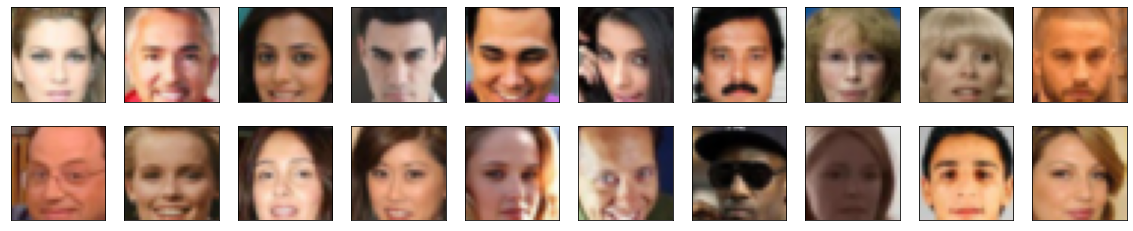

In [4]:
def imshow(img):
    '''Takes in image tensor and displays it'''
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Get a batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot 20 images images from the batch
fig = plt.figure(figsize = (20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size / 2, idx + 1, xticks = [], yticks = [])
    imshow(images[idx])

Everything seems right. The images are squares and contain just the faces.

### Rescaling

Right now, the images are in a range of 0 to 1 but they need to be in [-1, 1]. You may wonder why. Discriminator will have to work both with training images and generated ones. Since the generator uses `tanh` activation and outputs images in a range of [-1, 1], it will be easier to rescale the training images in this way.

I'm going to write a rescaling function that I will use later.

In [5]:
def scale(x, feature_range = (-1, 1)):
    '''Takes in an image x in a range [0, 1] and returns that image rescaled to given range'''
    # Scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [6]:
# Test it on a single image
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8745)
Max:  tensor(1.)


I also made a little test and applied it to a sample image. Minimum value is greater than -1 and maximum is below 1. It works correctly.

# Define the GAN

GAN consists of two individual neural networks, a discriminator and a generator.

### Discriminator

Let's start with the discriminator. It's going to be a CNN but without pooling layers a usual. Its job is to take in an input image (32, 32, 3) and output 1 if the image is real or 0 in the other case.

I won't use maxpooling but you still want to downsample an image. You can do it by creating a convolutional layer with a kernel of (4, 4) and a stride of 2. It is going to reduce the image size by 2. That being said, I will use just 3 layers. It will take an input image from (32, 32) -> (16, 16) -> (8, 8) -> (4, 4). I don't want to downsample it more than that, because smaller image could possibly loose too much of the original info.

The output needs to be an integer (a single score that will be later translated into probability). So at the end, I will use a fully-connected layer to get a single number.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Conv + batch norm unit
def conv(in_channels, 
         out_channels, 
         kernel_size, 
         stride = 2, 
         padding = 1, 
         batch_norm = True):
    '''Create a convolutional layer, with optional batch normalization.'''
    
    # Conv layer
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels, 
                           out_channels = out_channels, 
                           kernel_size = kernel_size, 
                           stride = stride, 
                           padding = padding, 
                           bias = False)
    layers.append(conv_layer)
    
    # Optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [8]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        '''Initialize layers.
        
        Args:
            conv_dim(int): number of feature maps in the first convolutional layer
        '''
        super(Discriminator, self).__init__()

        # Define convolutional layers
        self.conv1 = conv(in_channels = 3, 
                          out_channels = conv_dim, 
                          kernel_size = (4, 4), 
                          batch_norm = False) # (32, 32, 3) -> (16, 16, conv_dim)
        self.conv2 = conv(in_channels = conv_dim, 
                          out_channels = conv_dim * 2, 
                          kernel_size = (4, 4)) # (16, 16, conv_dim) -> (8, 8, conv_dim * 2)
        self.conv3 = conv(in_channels = conv_dim * 2, 
                          out_channels = conv_dim * 4, 
                          kernel_size = (4, 4)) # (8, 8, conv_dim * 2) -> (4, 4, conv_dim * 4)
        self.conv4 = conv(in_channels = conv_dim * 4, 
                          out_channels = 1, 
                          kernel_size = (1, 1),
                          stride = 1,
                          padding = 0) # (4, 4, conv_dim * 4) -> (4, 4, 1)
        
        # Last, fully-connected layer
        self.fc = nn.Linear(4 * 4 * 1, 1)
        

    def forward(self, x):
        '''Forward propagation.
        
        Args:
            x(Tensor): input of size (batch_size, 32, 32, 3)   
        
        Returns: logit values (batch_size, 1), score value for every observation in a batch
        '''
        batch_size = x.shape[0]

        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # Flatten
        x = x.view(batch_size, -1, )

        out = self.fc(x)
        
        return out

# Test
tests.test_discriminator(Discriminator)

Tests Passed


### Generator

Generator takes in a vector from a latent space, which simply put is a random vector. Then it upsamples the input using transpose convolutional layers until it reaches the image size (32, 32, 3).

But you cannot simply pass into convolutional layers a 2D vector. You need to reshape it first into 3D. So at the beginning I'm going to use a fully-connected layer. It will take in a vector z and scale its length up so it can be easily reshaped into image of size (4, 4, x). And then will follow transpose convolutional layers.

In [9]:
def deconv(in_channels, 
           out_channels, 
           kernel_size, 
           stride = 2, 
           padding = 1, 
           batch_norm = True):
    '''Create a transpose convolutional layer, with optional batch normalization'''
    
    # Transpose conv layer
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, 
                                     out_channels, 
                                     kernel_size, 
                                     stride, 
                                     padding, 
                                     bias = False))
    
    # Optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        '''Initialize layers.
        
        Args:
            z_size(int): length of the latent vector z
            conv_dim(int): number of feature maps passed into the last layer
        '''
        super(Generator, self).__init__()
        
        # Define fully-connected layer
        self.fc = nn.Linear(z_size, 4 * 4 * conv_dim * 4)

        # Define transpose convolutional layers
        self.deconv1 = deconv(in_channels = conv_dim * 4, 
                              out_channels = conv_dim * 2, 
                              kernel_size = (4, 4)) # (4, 4, conv_dim * 4) -> (8, 8, conv_dim * 2)
        self.deconv2 = deconv(in_channels = conv_dim * 2, 
                              out_channels = conv_dim, 
                              kernel_size = (4, 4)) # (8, 8, conv_dim * 2) -> (16, 16, conv_dim)
        self.deconv3 = deconv(in_channels = conv_dim, 
                              out_channels = 3, 
                              kernel_size = (4, 4),
                              batch_norm = False) # (16, 16, conv_dim) -> (32, 32, 3)
        

    def forward(self, x):
        '''Forward propagation.
        
        Args:
            x(Tensor): input of_size(batch_size, z_size)   
        
        Returns: tensor image of size (32, 32, 3)
        '''
        
        batch_size = x.shape[0]
        
        # Reshape the vector into 3D (batch_size, channels, h, w)
        x = F.leaky_relu(self.fc(x), 0.2) # (batch,size, z_len) -> (batch_size, conv_dim * 4, 4, 4)
        x = x.reshape(batch_size, -1, 4, 4)
        
        # Upscale
        x = F.leaky_relu(self.deconv1(x), 0.2)
        x = F.leaky_relu(self.deconv2(x), 0.2)
        out = torch.tanh(self.deconv3(x)) # tanh
        
        return out

# Test
tests.test_generator(Generator)

Tests Passed


### Weight initialization

You can always use custom weights initialization to improve model's performance. I am going to write a function for it here.

I will initialize weights with values from a normal distribution with mean 0 and standard deviation of 0.02, exactly like in the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf). To help with the coding task, I base my code on [this fragment](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) from CycleGAN Github repository. I want to apply this strategy to convolutional and linear layers. Batch normalization layers will be initialized similarly but with mean of 1.

In [11]:
def weights_init_normal(m):
    '''Sets initial weights to convolutional and linear layers of a model.
    Takes the weights from a normal distribution N(0, 0.02).
    
    Args:
        m: a module or layer in a network   
    '''
    # Classname takes the form something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    mean = 0.0
    std_dev = 0.02
    
    # Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        # Normal initialization, N(0, 0.02)
        nn.init.normal_(m.weight.data, mean, std_dev)

        # Init bias with 0
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

    # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, std_dev)
        nn.init.constant_(m.bias.data, 0.0)

### Build the model

Now I am going to write the code that intializes the disciminator with the generator and returns them. It will make use of input hyperparameters and apply the custom weight initialization that you saw before.

In [12]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # Init discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size = z_size, conv_dim = g_conv_dim)

    # Initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

### Define the model's hyperparameters

I am going to experiment with 3 parameter values. They are the length of vector z and the number of feature maps in both discriminator and generator.

In [13]:
# Hyperparameters
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

# Build the model with them
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(8, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## Define loss functions

Total loss of the discriminator is the sum of two smaller losses, the one on real images and the other one on fakes.

Since the generator want to trick the discriminator into believing that created pictures are real, its loss is adversary. It means that you only need to flip the labels and you can use the same loss function.

I'm going to implement the functions using binary cross entropy. For real loss I'm going to use label smoothing. It changes the label from 1.0 to 0.9 and helps the discriminator to generalize better.

In [14]:
def real_loss(D_out, smooth = False):
    '''The measure of discriminator's error on real images.
    
    Args:
        D_out(tensor): discriminator logits

    Returns: real loss (int)
    '''    
    # Label smoothing
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    # Move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    
    # Numerically stable loss (with logits)
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''The measure of discriminator's error on fake images.
    
    Args:
        D_out(tensor): discriminator logits

    Returns: fake loss (int)
    '''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    # Move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

Based on the original paper, you want to use Adam optimizer with `lr` of 0.0002 `beta1` equal to 0.5. As for the `beta2`, it should be a number very close to 1 like 0.999, as can be read [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

In [15]:
import torch.optim as optim

# Parameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training code

Training a GAN is based on switching between the discriminator and the generator. I will briefly sum up for you, how each training loop looks like.

I start with the discriminator and calculate its real loss on a batch of training images. Then, I generate a batch of fake images and use them to compute the fake loss. Sum of real and fake losses gives you a total loss of the discriminator. With that, I perform backpropagation and weight update on it.

Next, I use the previously generated batch of images to calculate the loss of the generator. And here I use the trick of flipping labels. I calculcate the generator's loss using fake images but using formula for real loss. The intuiton behind it is that it wants to fool the discriminator that its fake images are real. Once this loss is calculated, I perform backward pass and optimization on the model.

Let's implement the training code.

In [16]:
# Check for a GPU first
train_on_gpu = torch.cuda.is_available()

# Print the result
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [17]:
def train(D, G, n_epochs, print_every = 702):
    '''Train GAN for a given number of epochs.
    
    Args:
        D: the discriminator network
        G: the generator network
        n_epochs(int): number of epochs to train for
        print_every(int): affects how often losses are printed and recorded
    
    Returns: discriminator and generator losses.
    '''
    
    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow you to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size = (sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # Move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Epoch training loop
    for epoch in range(n_epochs):

        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader, 1):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            # Move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # Add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================

            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # Use real loss to flip labels

            # Perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # =========================================
            #            TRAINING STATS
            # =========================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch + 1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # Generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # Finally return losses
    return losses

Now you can just set the desired number of epochs and train the model.

In [18]:
# Set number of epochs 
n_epochs = 500

# Train and get the loss
losses = train(D, G, n_epochs = n_epochs)

Epoch [    1/  500] | d_loss: 1.1385 | g_loss: 0.9978
Epoch [    2/  500] | d_loss: 1.2652 | g_loss: 0.7432
Epoch [    3/  500] | d_loss: 0.9968 | g_loss: 1.1839
Epoch [    4/  500] | d_loss: 1.0401 | g_loss: 1.0337
Epoch [    5/  500] | d_loss: 1.3423 | g_loss: 0.6914
Epoch [    6/  500] | d_loss: 0.9640 | g_loss: 1.3538
Epoch [    7/  500] | d_loss: 1.0466 | g_loss: 0.7675
Epoch [    8/  500] | d_loss: 1.1688 | g_loss: 0.3008
Epoch [    9/  500] | d_loss: 1.4322 | g_loss: 0.5433
Epoch [   10/  500] | d_loss: 1.1293 | g_loss: 2.0488
Epoch [   11/  500] | d_loss: 0.9430 | g_loss: 0.6488
Epoch [   12/  500] | d_loss: 0.8668 | g_loss: 1.1924
Epoch [   13/  500] | d_loss: 1.1480 | g_loss: 1.2999
Epoch [   14/  500] | d_loss: 0.9022 | g_loss: 2.0889
Epoch [   15/  500] | d_loss: 1.4277 | g_loss: 1.8752
Epoch [   16/  500] | d_loss: 0.9543 | g_loss: 0.9437
Epoch [   17/  500] | d_loss: 0.9018 | g_loss: 0.6436
Epoch [   18/  500] | d_loss: 0.5607 | g_loss: 2.3729
Epoch [   19/  500] | d_loss

Now that the training is complete, let's evaluate its results. I'm going to plot the losses that were recorded after each epoch.

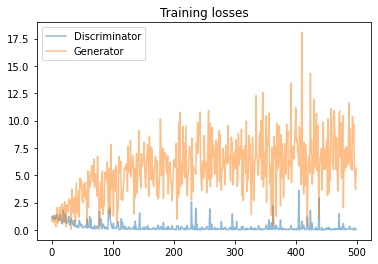

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label = 'Discriminator', alpha = 0.5)
plt.plot(losses.T[1], label = 'Generator', alpha = 0.5)
plt.title('Training losses')
plt.legend()

I trained the model for 500 epochs but it looks like it converged faster at around 200th epoch. It's always good to know that the model has converged during training. You can tell it because from this point, the generator's loss seems to fluctuate around the same average value.

## Generator samples

Now I'm going to print sample faces that were generated during training. You will be able to observe how the generator has improved over time.

In [20]:
# Print a list of sample images from a given epoch
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize = (16, 4), 
                             nrows = 2, 
                             ncols = 8, 
                             sharey = True, 
                             sharex = True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1) * 255 / 2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32, 32, 3)))

In [21]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Sample images from epoch 50:



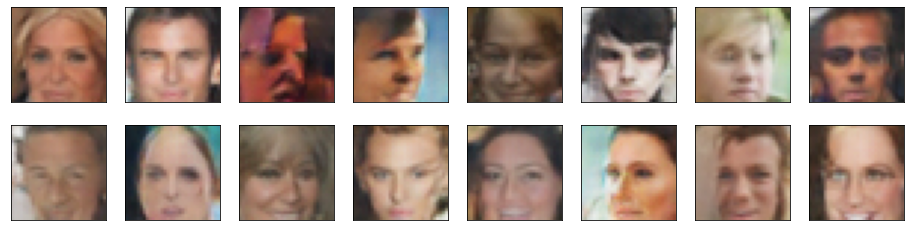

Sample images from epoch 100:



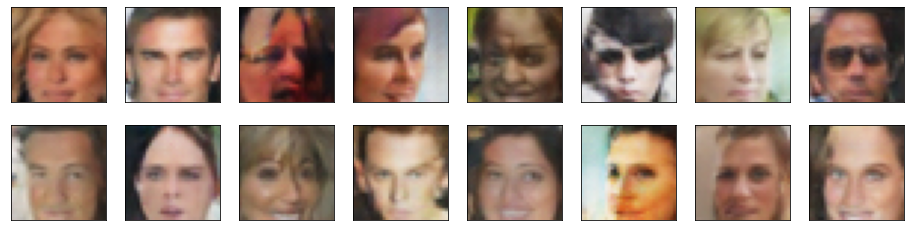

Sample images from epoch 200:



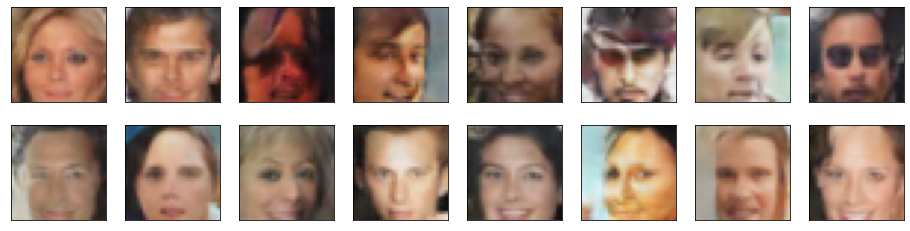

Sample images from epoch 300:



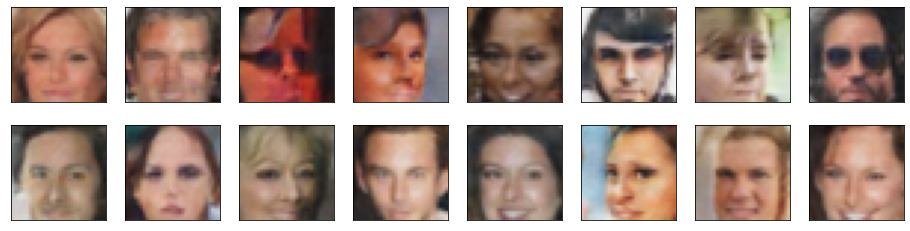

Sample images from epoch 400:



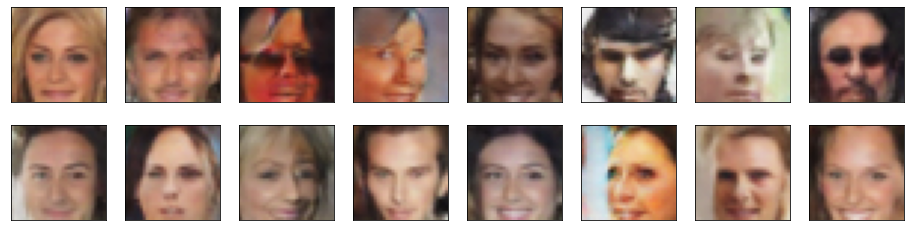

Sample images from epoch 500:



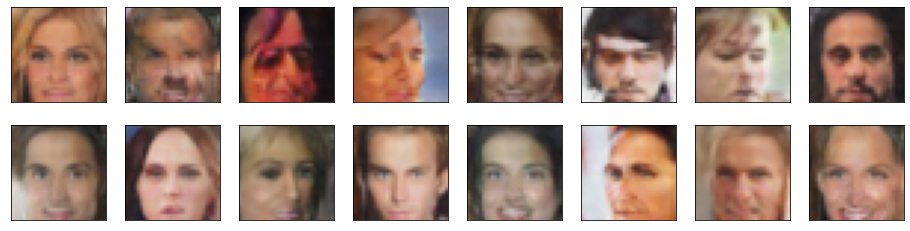

In [22]:
# Epochs at which to print samples
epochs_to_print = [ 50, 100, 200, 300, 400, 500]

# Print samples at these epochs
for epoch in epochs_to_print:
    print('Sample images from epoch {}:\n'.format(epoch))
    view_samples(epoch - 1, samples)

This is quite informative. You can see that the training up to 500 epochs actually made sense. It looks like that face quality has on average continued to improve.

For example, when comparing samples between epochs 400th and 500th, you can notice that faces 4th and 8th improved in terms of eyes. On the other hand, comparing between the same epochs, faces 2nd and 3rd have worsened and look less real.

## Possible improvements

I can think of at least a few ways in which the model could be improved.

The dataset is biased as it contains mostly pictures of western celebrities. To change it, you can add to the training set more faces of regular people.

Loss changes noticeably up to around 200th epoch and then sort of stagnates. This can mean that after reaching a certain image quality, the model has problems with further improvement. It is poosible that it makes too big optimization steps after that given epoch. You can fix it by reducing the learning rate with time.

You can also increase the model's learning capacity by adding more layers. Larger model takes more time to train so you don't want to do it until it clearly performs better.